# JQA NER Models Evaluator

Reads-in dataframe of predicted (recognized) and actual (encoded) results and compares accuracy of different NER models.

In [16]:
# Import necessary libraries.
import re, warnings, glob, csv, sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz, process
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Ignore warnings related to deprecated functions.
warnings.simplefilter("ignore") # specify ignore: , DeprecationWarning

# Declare directory location to shorten filepaths later.
abs_dir = "/Users/quinn.wi/Documents/SemanticData/"

# Read in data.
data = pd.read_csv(abs_dir + 'Output/NER/ner-model-comparisons_testing.csv', sep = ',')

data.head()

,file,entry,element,entity,model,found_entities,found_entity,entity_label,confidence
0,TestData_JQADiaries-v23-1825-01-p403,jqadiaries-v23-1825-01-02,persName,Baker’s,custom_spacy,NaN,NaN,NaN,20
1,TestData_JQADiaries-v23-1825-01-p403,jqadiaries-v23-1825-01-02,persName,Baker’s,custom_stanford,NaN,NaN,NaN,20
2,TestData_JQADiaries-v23-1825-01-p403,jqadiaries-v23-1825-01-02,persName,Baker’s,nltk,"('Heard Lynd', 'PERSON')",Heard Lynd,PERSON,35
3,TestData_JQADiaries-v23-1825-01-p403,jqadiaries-v23-1825-01-02,persName,Baker’s,spacy,"('Baker', 'PERSON')",Baker,PERSON,83
4,TestData_JQADiaries-v23-1825-01-p403,jqadiaries-v23-1825-01-02,persName,Baker’s,stanford,"('Baker', 'PERSON')",Baker,PERSON,83


## Declare Match Status

In [17]:
%%time

# Set confidence filter.
confidence_filter = 50

# Define function to declare match quality using confidence score.
# Function will return [0, 0] for a match and [0, 1] for a mismatch.
# Each value in the list will become a column value.
def get_match_quality(confidence_score):
    if confidence_score >= confidence_filter:
        values = [1, 1]
    else:
        values = [1, 0]
    return values

# Return two columns with zip + apply.
data['enc_match_val'], data['ner_match_val'] = zip(*data['confidence'] \
                                                   .apply(get_match_quality))

data.head()

CPU times: user 3.68 ms, sys: 97 µs, total: 3.77 ms
Wall time: 3.69 ms


,file,entry,element,entity,model,found_entities,found_entity,entity_label,confidence,enc_match_val,ner_match_val
0,TestData_JQADiaries-v23-1825-01-p403,jqadiaries-v23-1825-01-02,persName,Baker’s,custom_spacy,NaN,NaN,NaN,20,1,0
1,TestData_JQADiaries-v23-1825-01-p403,jqadiaries-v23-1825-01-02,persName,Baker’s,custom_stanford,NaN,NaN,NaN,20,1,0
2,TestData_JQADiaries-v23-1825-01-p403,jqadiaries-v23-1825-01-02,persName,Baker’s,nltk,"('Heard Lynd', 'PERSON')",Heard Lynd,PERSON,35,1,0
3,TestData_JQADiaries-v23-1825-01-p403,jqadiaries-v23-1825-01-02,persName,Baker’s,spacy,"('Baker', 'PERSON')",Baker,PERSON,83,1,1
4,TestData_JQADiaries-v23-1825-01-p403,jqadiaries-v23-1825-01-02,persName,Baker’s,stanford,"('Baker', 'PERSON')",Baker,PERSON,83,1,1


## Measure Accuracy of Models

Accuracy measures how many NER results match the encoding of place- and persNames. 

1. Precision Score 
> Model precision score represents the model’s ability to correctly predict <mark>the positives out of all the positive predictions</mark> it made. Precision score is a useful measure of success of prediction when the classes are very imbalanced. Mathematically, it represents the ratio of true positive to the sum of true positive and false positive.

   * Optimize for precision helps with correctness if the patient has a malignant cancer. However, this comes at the cost of missing malignant cancer more frequently (a high number of FN).

2. Recall Score
> Model recall score represents the model’s ability to correctly predict <mark>the positives out of actual positives</mark>. This is unlike precision which measures as to how many predictions made by models are actually positive out of all positive predictions made. Recall score is a useful measure of success of prediction when the classes are very imbalanced.  Mathematically, it represents the ratio of true positive to the sum of true positive and false negative.

   * Optimizing for recall helps with minimizing the chance of not detecting a malignant cancer. However, this comes at the cost of predicting malignant cancer in patients although the patients are healthy (a high number of FP).    
    
3. Accuracy Score
> Model accuracy score represents the model’s ability to correctly <mark>predict both the positives and negatives out of all the predictions</mark>. Mathematically, it represents the ratio of sum of true positive and true negatives out of all the predictions.

4. F1-Score
>Model F1 score represents the model score as a function of precision and recall score. This is useful measure of the model in the scenarios where one tries to optimize either of precision or recall score and as a result, the model performance suffers. The following represents the aspects relating to issues with optimizing either precision or recall score:

#### Source

Kumar, Ajitesh, "[Accuracy, Precision, Recall & F1-Score—Python Examples](https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/)," <i>Data Analytics</i>, Accessed October 20, 2020.

Explanation of 'weighted,' 'micro,' and 'macro' averaging in sklearn metrics:

https://datascience.stackexchange.com/questions/40900/whats-the-difference-between-sklearn-f1-score-micro-and-weighted-for-a-mult

Sklearn Documentation
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html

In [22]:
%%time

# Collect column values by group.
encoded_vals = data.groupby('model')['enc_match_val'] \
    .apply(list).reset_index(name = 'enc_match_val')

# Collect column values by group.
ner_vals = data.groupby('model')['ner_match_val'] \
    .apply(list).reset_index(name = 'ner_match_val')

# Combine values into dataframe for accuracy measurement.
accuracy_df = pd.merge(encoded_vals, ner_vals, on = 'model', how = 'inner')


# Measure precision of each group.
accuracy_df['precision'] = accuracy_df \
    .apply(lambda row: precision_score(row['enc_match_val'], row['ner_match_val'],
                                       average = 'micro'), axis = 1)

# Measure recall of each group.
accuracy_df['recall'] = accuracy_df \
    .apply(lambda row: recall_score(row['enc_match_val'], row['ner_match_val'],
                                    average = 'micro'), axis = 1)

# Measure accuracy of each group.
accuracy_df['accuracy'] = accuracy_df \
    .apply(lambda row: accuracy_score(row['enc_match_val'], row['ner_match_val']),
           axis = 1)

# Measure f-1 score of each group.
accuracy_df['f1-score'] = accuracy_df \
    .apply(lambda row: f1_score(row['enc_match_val'], row['ner_match_val'],
                                average = 'micro'), axis = 1)

# Tidy up data.
results_df = pd.melt(accuracy_df,
                     id_vars = ['model'],
                     value_vars = ['precision', 'recall', 'accuracy', 'f1-score'],
                     var_name = 'metric', value_name = 'score')


# Measure accuracy of each model
print ('Simple Accuracy (correct observations / total observations) by Model:\n')
for i, r in accuracy_df.iterrows():
#     Count total mismatches; 1 = mismatch/error.
    errors = r['ner_match_val'].count(0)
#     Measure accuracy: total observations minus errors divided by total observations.
    accuracy = (len(r['ner_match_val']) - errors) / len(r['ner_match_val'])
    print (r['model'], f':\t{accuracy:.2f}%')

results_df

Simple Accuracy (correct observations / total observations) by Model:

custom_spacy :	0.04%
custom_stanford :	0.04%
nltk :	0.48%
spacy :	0.54%
stanford :	0.51%
CPU times: user 44.6 ms, sys: 1.53 ms, total: 46.1 ms
Wall time: 45.1 ms


,model,metric,score
0,custom_spacy,precision,0.035088
1,custom_stanford,precision,0.035088
2,nltk,precision,0.480769
3,spacy,precision,0.543990
4,stanford,precision,0.510559
5,custom_spacy,recall,0.035088
6,custom_stanford,recall,0.035088
7,nltk,recall,0.480769
8,spacy,recall,0.543990
9,stanford,recall,0.510559


In [26]:
%%time

from sklearn.metrics import average_precision_score

test = accuracy_df.query('model == "stanford"')

average_precision_score(test['enc_match_val'], test['enc_match_val'])

ValueError: You appear to be using a legacy multi-label data representation. Sequence of sequences are no longer supported; use a binary array or sparse matrix instead - the MultiLabelBinarizer transformer can convert to this format.

#### Visualize Model Differences

CPU times: user 237 ms, sys: 8.38 ms, total: 245 ms
Wall time: 246 ms


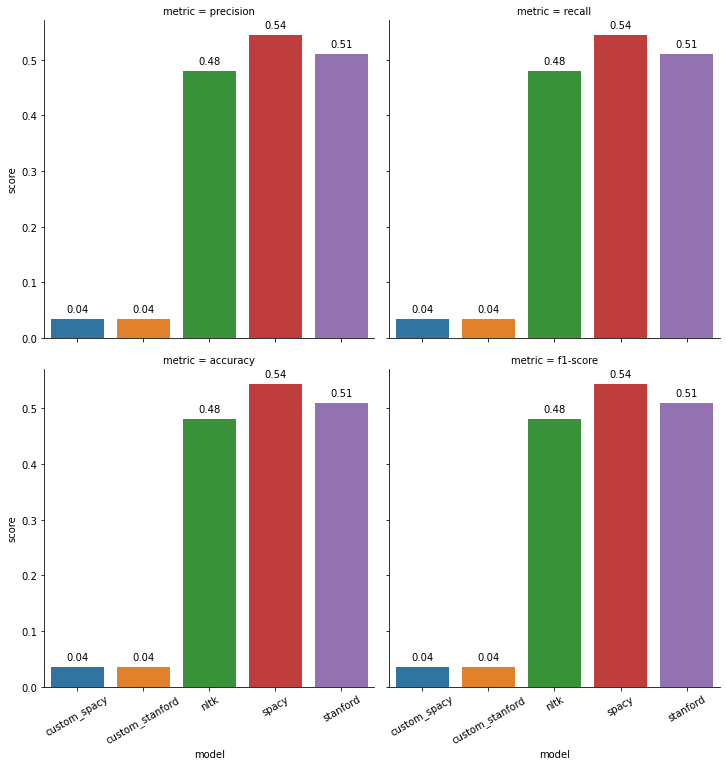

In [23]:
%%time

# Plot results.
g = sns.catplot(
    data = results_df, 
    col = 'metric', col_wrap = 2,
    kind = 'bar',
    x = 'model', y = 'score'
)

# Rotate x-axis labels.
g.set_xticklabels(rotation=30)

# Annotate values to tops of bars.
for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center', xytext = (0, 10),
                    textcoords = 'offset points')